In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
from PIL import Image
from tqdm import tqdm
import glob

In [2]:
# V2
import torch
import torch.nn as nn
import torch.nn.functional as F

class AODnet_MultiBranch(nn.Module):
    def __init__(self):
        super(AODnet_MultiBranch, self).__init__()
        print("[Model] Multi-Branch AODNet 초기화 중...")

        # ----- K1 Branch (작은 스케일 특징 담당) -----
        self.k1_conv1 = nn.Conv2d(3, 3, kernel_size=1)
        self.k1_conv2 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.k1_conv3 = nn.Conv2d(6, 3, kernel_size=5, padding=2)

        # ----- K2 Branch (중간 스케일 특징 담당) -----
        self.k2_conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.k2_conv2 = nn.Conv2d(3, 3, kernel_size=5, padding=2)
        self.k2_conv3 = nn.Conv2d(6, 3, kernel_size=7, padding=3)
        
        # ----- K3 Branch (큰 스케일 특징 담당) -----
        self.k3_conv1 = nn.Conv2d(3, 3, kernel_size=5, padding=2)
        self.k3_conv2 = nn.Conv2d(3, 3, kernel_size=7, padding=3)
        self.k3_conv3 = nn.Conv2d(6, 3, kernel_size=9, padding=4)

        # ----- 3개 브랜치의 결과를 융합(Fusion)하는 레이어 -----
        # 각 브랜치에서 3채널 결과가 나오므로 총 9채널을 입력받아 최종 3채널 k로 만듦
        self.fusion_conv = nn.Conv2d(9, 3, kernel_size=3, padding=1)
        
        self.b = 1 # 대기 산란 모델의 상수

        print("[Model] Multi-Branch AODNet 초기화 완료\n")


    def forward(self, x):
        # --- K1 Branch 연산 ---
        x1_1 = F.relu(self.k1_conv1(x))
        x1_2 = F.relu(self.k1_conv2(x1_1))
        k1_cat = torch.cat((x1_1, x1_2), dim=1)
        k1 = F.relu(self.k1_conv3(k1_cat)) # K1 결과

        # --- K2 Branch 연산 ---
        x2_1 = F.relu(self.k2_conv1(x))
        x2_2 = F.relu(self.k2_conv2(x2_1))
        k2_cat = torch.cat((x2_1, x2_2), dim=1)
        k2 = F.relu(self.k2_conv3(k2_cat)) # K2 결과

        # --- K3 Branch 연산 ---
        x3_1 = F.relu(self.k3_conv1(x))
        x3_2 = F.relu(self.k3_conv2(x3_1))
        k3_cat = torch.cat((x3_1, x3_2), dim=1)
        k3 = F.relu(self.k3_conv3(k3_cat)) # K3 결과

        # --- Fusion 단계 ---
        k_fused = torch.cat((k1, k2, k3), dim=1)
        k_final = F.relu(self.fusion_conv(k_fused)) # 최종 K

        # --- AOD-Net 복원 공식 적용 ---
        output = k_final * x - k_final + self.b
        return F.relu(output)



In [3]:
def print_model_summary(model, model_name):
    """모델의 파라미터 정보와 총 개수를 출력하는 함수"""
    print(f"========== {model_name} Summary ==========")
    
    # 모델의 각 파라미터 이름과 크기(shape) 출력
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name},  Shape: {param.shape}")
    
    # 전체 파라미터 개수 계산 및 출력
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total_params:,}")
    print("=" * (len(model_name) + 24))
    print("\n")


# 1. AODnet 모델 객체 생성 및 파라미터 확인
model = AODnet_MultiBranch()
print_model_summary(model, "AODnet")

[Model] Multi-Branch AODNet 초기화 중...
[Model] Multi-Branch AODNet 초기화 완료

========== AODnet Summary ==========
Layer: k1_conv1.weight,  Shape: torch.Size([3, 3, 1, 1])
Layer: k1_conv1.bias,  Shape: torch.Size([3])
Layer: k1_conv2.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: k1_conv2.bias,  Shape: torch.Size([3])
Layer: k1_conv3.weight,  Shape: torch.Size([3, 6, 5, 5])
Layer: k1_conv3.bias,  Shape: torch.Size([3])
Layer: k2_conv1.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: k2_conv1.bias,  Shape: torch.Size([3])
Layer: k2_conv2.weight,  Shape: torch.Size([3, 3, 5, 5])
Layer: k2_conv2.bias,  Shape: torch.Size([3])
Layer: k2_conv3.weight,  Shape: torch.Size([3, 6, 7, 7])
Layer: k2_conv3.bias,  Shape: torch.Size([3])
Layer: k3_conv1.weight,  Shape: torch.Size([3, 3, 5, 5])
Layer: k3_conv1.bias,  Shape: torch.Size([3])
Layer: k3_conv2.weight,  Shape: torch.Size([3, 3, 7, 7])
Layer: k3_conv2.bias,  Shape: torch.Size([3])
Layer: k3_conv3.weight,  Shape: torch.Size([3, 6, 9, 9])
Layer: k3

In [5]:
class DehazeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        :param data_dir: train, test, val 폴더 중 하나의 경로 (예: 'dataset2_split/train')
        :param transform: 이미지에 적용할 torchvision.transforms
        """
        self.gt_dir = os.path.join(data_dir, 'gt')
        self.input_dir = os.path.join(data_dir, 'input')
        self.transform = transform
        
        # input 폴더의 파일 목록을 기준으로 삼음
        self.image_files = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        
        input_path = os.path.join(self.input_dir, filename)
        gt_path = os.path.join(self.gt_dir, filename)
        
        # PIL 라이브러리를 사용해 이미지 열기 (RGB 형식으로 변환)
        input_image = Image.open(input_path).convert('RGB')
        gt_image = Image.open(gt_path).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)
            
        return input_image, gt_image

In [6]:
# GPU 사용 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# 하이퍼파라미터
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 100

# 데이터셋 경로 (split_dataset.py 실행 후 생성된 폴더)
DATA_DIR = "./dataset_split"
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

# 학습된 모델 가중치를 저장할 경로
MODEL_SAVE_PATH = "./pt/TBaodNet5"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Using device: cuda


In [7]:
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((240, 360)), # 이미지 크기를 256x256으로 조절 H, W 순서
    transforms.ToTensor()          # 이미지를 PyTorch 텐서로 변환 (0~1 값으로 정규화)
])

# 훈련 데이터셋 및 데이터 로더
train_dataset = DehazeDataset(data_dir=TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 검증 데이터셋 및 데이터 로더
val_dataset = DehazeDataset(data_dir=VAL_DIR, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"훈련 데이터셋 크기: {len(train_dataset)}개")
print(f"검증 데이터셋 크기: {len(val_dataset)}개")

# 셀 5 실행 후 이 코드를 실행해보세요
try:
    input_img, gt_img = train_dataset[0]
    print("데이터셋 로딩 성공!")
    print("Input 이미지 텐서 모양:", input_img.shape)
    print("GT 이미지 텐서 모양:", gt_img.shape)
except Exception as e:
    print("데이터셋 로딩 중 오류 발생:", e)

훈련 데이터셋 크기: 3543개
검증 데이터셋 크기: 507개
데이터셋 로딩 성공!
Input 이미지 텐서 모양: torch.Size([3, 240, 360])
GT 이미지 텐서 모양: torch.Size([3, 240, 360])


In [8]:
# 모델 인스턴스 생성 및 GPU로 이동
# model = AODnet().to(DEVICE) # 기본 모델을 사용하려면 이 줄의 주석을 해제
model = AODnet_MultiBranch().to(DEVICE) # PONO 모델 사용
print("Model:", model.__class__.__name__)

# 손실 함수 (Loss Function) - 이미지 복원에는 MSE Loss가 일반적으로 사용됨
criterion = nn.MSELoss()

# 옵티마이저 (Optimizer) - Adam이 안정적이고 좋은 성능을 보임
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

[Model] Multi-Branch AODNet 초기화 중...
[Model] Multi-Branch AODNet 초기화 완료

Model: AODnet_MultiBranch


In [15]:
# 각 에폭의 손실 값을 저장할 리스트 생성
train_loss_history = [] # <<< 추가
val_loss_history = []   # <<< 추가

best_val_loss = float('inf')

print("\n===== 모델 학습을 시작합니다 =====")
for epoch in range(NUM_EPOCHS):
    # --- 훈련 단계 ---
    model.train()
    train_loss = 0.0
    
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for hazy_images, clean_images in train_iterator:
        hazy_images = hazy_images.to(DEVICE)
        clean_images = clean_images.to(DEVICE)
        
        outputs = model(hazy_images)
        loss = criterion(outputs, clean_images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
        
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss) # <<< 추가

    # --- 검증 단계 ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for hazy_images, clean_images in val_iterator:
            hazy_images = hazy_images.to(DEVICE)
            clean_images = clean_images.to(DEVICE)
            
            outputs = model(hazy_images)
            loss = criterion(outputs, clean_images)
            val_loss += loss.item()
            val_iterator.set_postfix({'loss': loss.item()})
            
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss) # <<< 추가
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_file = os.path.join(MODEL_SAVE_PATH, f"best_model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), save_file)
        print(f"***** Best model saved to {save_file} (Val Loss: {best_val_loss:.6f}) *****\n")

print("\n===== 모든 학습이 완료되었습니다! =====")


===== 모델 학습을 시작합니다 =====


Epoch 1/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.87it/s, loss=0.0171]


Epoch [1/100], Train Loss: 0.027576, Val Loss: 0.025604
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_1.pth (Val Loss: 0.025604) *****



Epoch 2/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.01it/s, loss=0.0156]


Epoch [2/100], Train Loss: 0.024951, Val Loss: 0.024743
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_2.pth (Val Loss: 0.024743) *****



Epoch 3/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.00it/s, loss=0.0133]


Epoch [3/100], Train Loss: 0.024267, Val Loss: 0.023608
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_3.pth (Val Loss: 0.023608) *****



Epoch 4/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s, loss=0.0146]


Epoch [4/100], Train Loss: 0.023913, Val Loss: 0.023705


Epoch 5/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s, loss=0.0121]


Epoch [5/100], Train Loss: 0.023597, Val Loss: 0.023068
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_5.pth (Val Loss: 0.023068) *****



Epoch 6/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.07it/s, loss=0.0116]


Epoch [6/100], Train Loss: 0.023398, Val Loss: 0.022878
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_6.pth (Val Loss: 0.022878) *****



Epoch 7/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.03it/s, loss=0.012] 


Epoch [7/100], Train Loss: 0.023181, Val Loss: 0.022714
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_7.pth (Val Loss: 0.022714) *****



Epoch 8/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.90it/s, loss=0.0122]


Epoch [8/100], Train Loss: 0.023124, Val Loss: 0.022662
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_8.pth (Val Loss: 0.022662) *****



Epoch 9/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.86it/s, loss=0.0102] 


Epoch [9/100], Train Loss: 0.023107, Val Loss: 0.022782


Epoch 10/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.07it/s, loss=0.0111] 


Epoch [10/100], Train Loss: 0.022911, Val Loss: 0.022415
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_10.pth (Val Loss: 0.022415) *****



Epoch 11/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s, loss=0.0124]


Epoch [11/100], Train Loss: 0.022838, Val Loss: 0.022558


Epoch 12/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.10it/s, loss=0.0108] 


Epoch [12/100], Train Loss: 0.022855, Val Loss: 0.022303
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_12.pth (Val Loss: 0.022303) *****



Epoch 13/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.04it/s, loss=0.0118]


Epoch [13/100], Train Loss: 0.022769, Val Loss: 0.022366


Epoch 14/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s, loss=0.0107] 


Epoch [14/100], Train Loss: 0.022670, Val Loss: 0.022193
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_14.pth (Val Loss: 0.022193) *****



Epoch 15/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.00it/s, loss=0.0105] 


Epoch [15/100], Train Loss: 0.022661, Val Loss: 0.022170
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_15.pth (Val Loss: 0.022170) *****



Epoch 16/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s, loss=0.0108] 


Epoch [16/100], Train Loss: 0.022608, Val Loss: 0.022103
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_16.pth (Val Loss: 0.022103) *****



Epoch 17/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.10it/s, loss=0.00979]


Epoch [17/100], Train Loss: 0.022574, Val Loss: 0.022187


Epoch 18/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.06it/s, loss=0.00932]


Epoch [18/100], Train Loss: 0.022459, Val Loss: 0.022328


Epoch 19/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s, loss=0.0109] 


Epoch [19/100], Train Loss: 0.022541, Val Loss: 0.022040
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_19.pth (Val Loss: 0.022040) *****



Epoch 20/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.04it/s, loss=0.00963]


Epoch [20/100], Train Loss: 0.022400, Val Loss: 0.022026
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_20.pth (Val Loss: 0.022026) *****



Epoch 21/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.10it/s, loss=0.0114]


Epoch [21/100], Train Loss: 0.022391, Val Loss: 0.022175


Epoch 22/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s, loss=0.00981]


Epoch [22/100], Train Loss: 0.022336, Val Loss: 0.021905
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_22.pth (Val Loss: 0.021905) *****



Epoch 23/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.06it/s, loss=0.0097] 


Epoch [23/100], Train Loss: 0.022381, Val Loss: 0.021910


Epoch 24/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, loss=0.01]   


Epoch [24/100], Train Loss: 0.022281, Val Loss: 0.021833
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_24.pth (Val Loss: 0.021833) *****



Epoch 25/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.00911]


Epoch [25/100], Train Loss: 0.022268, Val Loss: 0.022055


Epoch 26/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s, loss=0.00965]


Epoch [26/100], Train Loss: 0.022279, Val Loss: 0.021790
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_26.pth (Val Loss: 0.021790) *****



Epoch 27/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s, loss=0.0106] 


Epoch [27/100], Train Loss: 0.022212, Val Loss: 0.021862


Epoch 28/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.00962]


Epoch [28/100], Train Loss: 0.022171, Val Loss: 0.021770
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_28.pth (Val Loss: 0.021770) *****



Epoch 29/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s, loss=0.00907]


Epoch [29/100], Train Loss: 0.022154, Val Loss: 0.021960


Epoch 30/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.0109] 


Epoch [30/100], Train Loss: 0.022135, Val Loss: 0.021985


Epoch 31/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.22it/s, loss=0.01]   


Epoch [31/100], Train Loss: 0.022101, Val Loss: 0.021729
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_31.pth (Val Loss: 0.021729) *****



Epoch 32/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.20it/s, loss=0.0114]


Epoch [32/100], Train Loss: 0.022144, Val Loss: 0.022113


Epoch 33/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s, loss=0.00955]


Epoch [33/100], Train Loss: 0.022105, Val Loss: 0.021630
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_33.pth (Val Loss: 0.021630) *****



Epoch 34/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.00915]


Epoch [34/100], Train Loss: 0.022049, Val Loss: 0.021650


Epoch 35/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.22it/s, loss=0.00869]


Epoch [35/100], Train Loss: 0.022078, Val Loss: 0.021826


Epoch 36/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.10it/s, loss=0.00927]


Epoch [36/100], Train Loss: 0.022002, Val Loss: 0.021584
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_36.pth (Val Loss: 0.021584) *****



Epoch 37/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.27it/s, loss=0.0103] 


Epoch [37/100], Train Loss: 0.022023, Val Loss: 0.021692


Epoch 38/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.22it/s, loss=0.00904]


Epoch [38/100], Train Loss: 0.021963, Val Loss: 0.021743


Epoch 39/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s, loss=0.00903]


Epoch [39/100], Train Loss: 0.021952, Val Loss: 0.021583
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_39.pth (Val Loss: 0.021583) *****



Epoch 40/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, loss=0.00985]


Epoch [40/100], Train Loss: 0.021873, Val Loss: 0.021583


Epoch 41/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s, loss=0.0105] 


Epoch [41/100], Train Loss: 0.021912, Val Loss: 0.021740


Epoch 42/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.00879]


Epoch [42/100], Train Loss: 0.021850, Val Loss: 0.021530
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_42.pth (Val Loss: 0.021530) *****



Epoch 43/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.0103] 


Epoch [43/100], Train Loss: 0.021927, Val Loss: 0.021624


Epoch 44/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, loss=0.00898]


Epoch [44/100], Train Loss: 0.022024, Val Loss: 0.021459
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_44.pth (Val Loss: 0.021459) *****



Epoch 45/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, loss=0.0101] 


Epoch [45/100], Train Loss: 0.021875, Val Loss: 0.021660


Epoch 46/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.19it/s, loss=0.00992]


Epoch [46/100], Train Loss: 0.021933, Val Loss: 0.021506


Epoch 47/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s, loss=0.0108] 


Epoch [47/100], Train Loss: 0.021812, Val Loss: 0.021932


Epoch 48/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s, loss=0.00864]


Epoch [48/100], Train Loss: 0.021794, Val Loss: 0.021641


Epoch 49/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.26it/s, loss=0.00912]


Epoch [49/100], Train Loss: 0.021840, Val Loss: 0.021394
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_49.pth (Val Loss: 0.021394) *****



Epoch 50/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.26it/s, loss=0.00951]


Epoch [50/100], Train Loss: 0.021846, Val Loss: 0.021423


Epoch 51/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s, loss=0.00927]


Epoch [51/100], Train Loss: 0.021723, Val Loss: 0.021372
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_51.pth (Val Loss: 0.021372) *****



Epoch 52/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.16it/s, loss=0.00915]


Epoch [52/100], Train Loss: 0.021760, Val Loss: 0.021401


Epoch 53/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.12it/s, loss=0.00918]


Epoch [53/100], Train Loss: 0.021845, Val Loss: 0.021365
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_53.pth (Val Loss: 0.021365) *****



Epoch 54/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, loss=0.00922]


Epoch [54/100], Train Loss: 0.021780, Val Loss: 0.021344
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_54.pth (Val Loss: 0.021344) *****



Epoch 55/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s, loss=0.00962]


Epoch [55/100], Train Loss: 0.021674, Val Loss: 0.021377


Epoch 56/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s, loss=0.00836]


Epoch [56/100], Train Loss: 0.021694, Val Loss: 0.021740


Epoch 57/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.29it/s, loss=0.00827]


Epoch [57/100], Train Loss: 0.021752, Val Loss: 0.021417


Epoch 58/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.10it/s, loss=0.00923]


Epoch [58/100], Train Loss: 0.021643, Val Loss: 0.021341
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_58.pth (Val Loss: 0.021341) *****



Epoch 59/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.28it/s, loss=0.00807]


Epoch [59/100], Train Loss: 0.021612, Val Loss: 0.021600


Epoch 60/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.26it/s, loss=0.00968]


Epoch [60/100], Train Loss: 0.021685, Val Loss: 0.021365


Epoch 61/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.32it/s, loss=0.00871]


Epoch [61/100], Train Loss: 0.021716, Val Loss: 0.021488


Epoch 62/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s, loss=0.00907]


Epoch [62/100], Train Loss: 0.021711, Val Loss: 0.021277
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_62.pth (Val Loss: 0.021277) *****



Epoch 63/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, loss=0.0089] 


Epoch [63/100], Train Loss: 0.021666, Val Loss: 0.021290


Epoch 64/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.30it/s, loss=0.00925]


Epoch [64/100], Train Loss: 0.021701, Val Loss: 0.021270
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_64.pth (Val Loss: 0.021270) *****



Epoch 65/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s, loss=0.0085] 


Epoch [65/100], Train Loss: 0.021698, Val Loss: 0.021260
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_65.pth (Val Loss: 0.021260) *****



Epoch 66/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s, loss=0.0094] 


Epoch [66/100], Train Loss: 0.021625, Val Loss: 0.021246
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_66.pth (Val Loss: 0.021246) *****



Epoch 67/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s, loss=0.0104] 


Epoch [67/100], Train Loss: 0.021634, Val Loss: 0.021556


Epoch 68/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.31it/s, loss=0.0089] 


Epoch [68/100], Train Loss: 0.021611, Val Loss: 0.021240
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_68.pth (Val Loss: 0.021240) *****



Epoch 69/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s, loss=0.00895]


Epoch [69/100], Train Loss: 0.021648, Val Loss: 0.021241


Epoch 70/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.16it/s, loss=0.01]   


Epoch [70/100], Train Loss: 0.021506, Val Loss: 0.021453


Epoch 71/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.22it/s, loss=0.00885]


Epoch [71/100], Train Loss: 0.021545, Val Loss: 0.021169
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_71.pth (Val Loss: 0.021169) *****



Epoch 72/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s, loss=0.00983]


Epoch [72/100], Train Loss: 0.021647, Val Loss: 0.021422


Epoch 73/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s, loss=0.00953]


Epoch [73/100], Train Loss: 0.021509, Val Loss: 0.021222


Epoch 74/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.27it/s, loss=0.0085] 


Epoch [74/100], Train Loss: 0.021534, Val Loss: 0.021165
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_74.pth (Val Loss: 0.021165) *****



Epoch 75/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.29it/s, loss=0.00909]


Epoch [75/100], Train Loss: 0.021492, Val Loss: 0.021149
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_75.pth (Val Loss: 0.021149) *****



Epoch 76/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s, loss=0.00921]


Epoch [76/100], Train Loss: 0.021515, Val Loss: 0.021173


Epoch 77/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s, loss=0.00954]


Epoch [77/100], Train Loss: 0.021529, Val Loss: 0.021322


Epoch 78/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.20it/s, loss=0.00997]


Epoch [78/100], Train Loss: 0.021506, Val Loss: 0.021332


Epoch 79/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s, loss=0.00852]


Epoch [79/100], Train Loss: 0.021470, Val Loss: 0.021187


Epoch 80/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s, loss=0.01]   


Epoch [80/100], Train Loss: 0.021523, Val Loss: 0.021378


Epoch 81/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s, loss=0.00823]


Epoch [81/100], Train Loss: 0.021525, Val Loss: 0.021920


Epoch 82/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.26it/s, loss=0.00947]


Epoch [82/100], Train Loss: 0.021382, Val Loss: 0.021209


Epoch 83/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s, loss=0.00919]


Epoch [83/100], Train Loss: 0.021409, Val Loss: 0.021157


Epoch 84/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.36it/s, loss=0.00904]


Epoch [84/100], Train Loss: 0.021438, Val Loss: 0.021126
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_84.pth (Val Loss: 0.021126) *****



Epoch 85/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.19it/s, loss=0.00828]


Epoch [85/100], Train Loss: 0.021398, Val Loss: 0.021146


Epoch 86/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, loss=0.00906]


Epoch [86/100], Train Loss: 0.021389, Val Loss: 0.021074
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_86.pth (Val Loss: 0.021074) *****



Epoch 87/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.28it/s, loss=0.0088] 


Epoch [87/100], Train Loss: 0.021423, Val Loss: 0.021023
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_87.pth (Val Loss: 0.021023) *****



Epoch 88/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s, loss=0.00898]


Epoch [88/100], Train Loss: 0.021328, Val Loss: 0.021219


Epoch 89/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.30it/s, loss=0.00836]


Epoch [89/100], Train Loss: 0.021459, Val Loss: 0.021043


Epoch 90/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.28it/s, loss=0.00915]


Epoch [90/100], Train Loss: 0.021317, Val Loss: 0.021063


Epoch 91/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.00848]


Epoch [91/100], Train Loss: 0.021348, Val Loss: 0.021123


Epoch 92/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, loss=0.0091] 


Epoch [92/100], Train Loss: 0.021365, Val Loss: 0.021117


Epoch 93/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s, loss=0.00926]


Epoch [93/100], Train Loss: 0.021322, Val Loss: 0.021054


Epoch 94/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s, loss=0.0092] 


Epoch [94/100], Train Loss: 0.021361, Val Loss: 0.021026


Epoch 95/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.07it/s, loss=0.0102] 


Epoch [95/100], Train Loss: 0.021305, Val Loss: 0.021363


Epoch 96/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s, loss=0.00875]


Epoch [96/100], Train Loss: 0.021315, Val Loss: 0.020951
***** Best model saved to ./pt/TBaodNet5\best_model_epoch_96.pth (Val Loss: 0.020951) *****



Epoch 97/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.12it/s, loss=0.00944]


Epoch [97/100], Train Loss: 0.021392, Val Loss: 0.021070


Epoch 98/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.00884]


Epoch [98/100], Train Loss: 0.021257, Val Loss: 0.020958


Epoch 99/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.19it/s, loss=0.00888]


Epoch [99/100], Train Loss: 0.021281, Val Loss: 0.021036


Epoch 100/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.20it/s, loss=0.0102] 

Epoch [100/100], Train Loss: 0.021290, Val Loss: 0.021309

===== 모든 학습이 완료되었습니다! =====


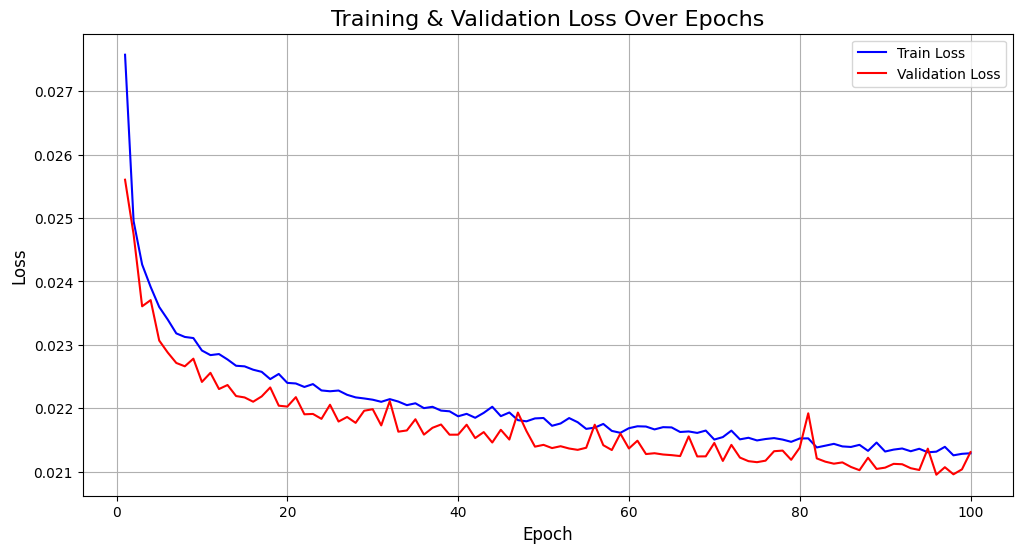

In [16]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 훈련 손실과 검증 손실 그래프 그리기
plt.plot(range(1, NUM_EPOCHS + 1), train_loss_history, label='Train Loss', color='blue')
plt.plot(range(1, NUM_EPOCHS + 1), val_loss_history, label='Validation Loss', color='red')

# 그래프 제목 및 축 레이블 설정
plt.title('Training & Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 범례 표시
plt.legend()

# 그리드 표시
plt.grid(True)

# 그래프 보여주기
plt.show()

In [10]:
# 새로운 셀

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 평가에 사용할 테스트셋 폴더 경로
TEST_DIR = os.path.join(DATA_DIR, 'test')

# 2. 불러올 학습된 모델 가중치 파일의 경로
# 'trained_models' 폴더 안에 저장된 .pth 파일 중 가장 성능이 좋았던(best) 모델의 경로를 지정합니다.
MODEL_WEIGHTS_PATH = "pt/TBaodNet5/best_model_epoch_71.pth" # XX 부분은 실제 파일 숫자로 변경
# --------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AODnet_MultiBranch().to(DEVICE)
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval() # 모델을 반드시 평가 모드로 설정!

# 테스트 데이터 로더 준비
test_dataset = DehazeDataset(data_dir=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0) # num_workers=0으로 설정

# 점수를 저장할 리스트 초기화
psnr_scores = []
ssim_scores = []

print(f"\n===== '{MODEL_WEIGHTS_PATH}' 모델 성능 평가 시작 =====")

# 평가 루프
with torch.no_grad(): # 기울기 계산 비활성화
    for hazy_images, clean_images in tqdm(test_loader, desc="Evaluating"):
        hazy_images = hazy_images.to(DEVICE)
        
        # 모델 추론
        outputs = evaluation_model(hazy_images)
        
        # GPU 텐서를 CPU의 Numpy 배열로 변환 (skimage 계산용)
        # (B, C, H, W) -> (B, H, W, C) 형태로 변경 및 0-255 범위의 정수형으로 변환
        outputs_np = outputs.cpu().permute(0, 2, 3, 1).numpy() * 255
        clean_images_np = clean_images.cpu().permute(0, 2, 3, 1).numpy() * 255
        
        outputs_np = outputs_np.astype(np.uint8)
        clean_images_np = clean_images_np.astype(np.uint8)
        
        # 배치 내의 각 이미지에 대해 점수 계산
        for i in range(clean_images_np.shape[0]):
            gt_image = clean_images_np[i]
            pred_image = outputs_np[i]
            
            # PSNR 계산
            psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=255)
            psnr_scores.append(psnr)
            
            # SSIM 계산
            # channel_axis=-1 은 컬러 이미지(RGB)의 채널 축을 지정해줍니다.
            ssim = structural_similarity(gt_image, pred_image, channel_axis=-1, data_range=255)
            ssim_scores.append(ssim)

# 평균 점수 계산
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print("\n===== 평가 완료 =====")
print(f"테스트 데이터셋 평균 PSNR: {avg_psnr:.4f} dB")
print(f"테스트 데이터셋 평균 SSIM: {avg_ssim:.4f}")

[Model] Multi-Branch AODNet 초기화 중...
[Model] Multi-Branch AODNet 초기화 완료


===== 'pt/TBaodNet5/best_model_epoch_71.pth' 모델 성능 평가 시작 =====


Evaluating: 100%|██████████| 127/127 [00:22<00:00,  5.54it/s]


===== 평가 완료 =====
테스트 데이터셋 평균 PSNR: 18.1997 dB
테스트 데이터셋 평균 SSIM: 0.7009


[Model] Multi-Branch AODNet 초기화 중...
[Model] Multi-Branch AODNet 초기화 완료

이미지 복원을 시작합니다...
'dataset_split/test/input/51_rain.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/im_0048_s95_a06.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/NYU2_1331.jpg' 복원 및 정답 이미지 로드 완료.


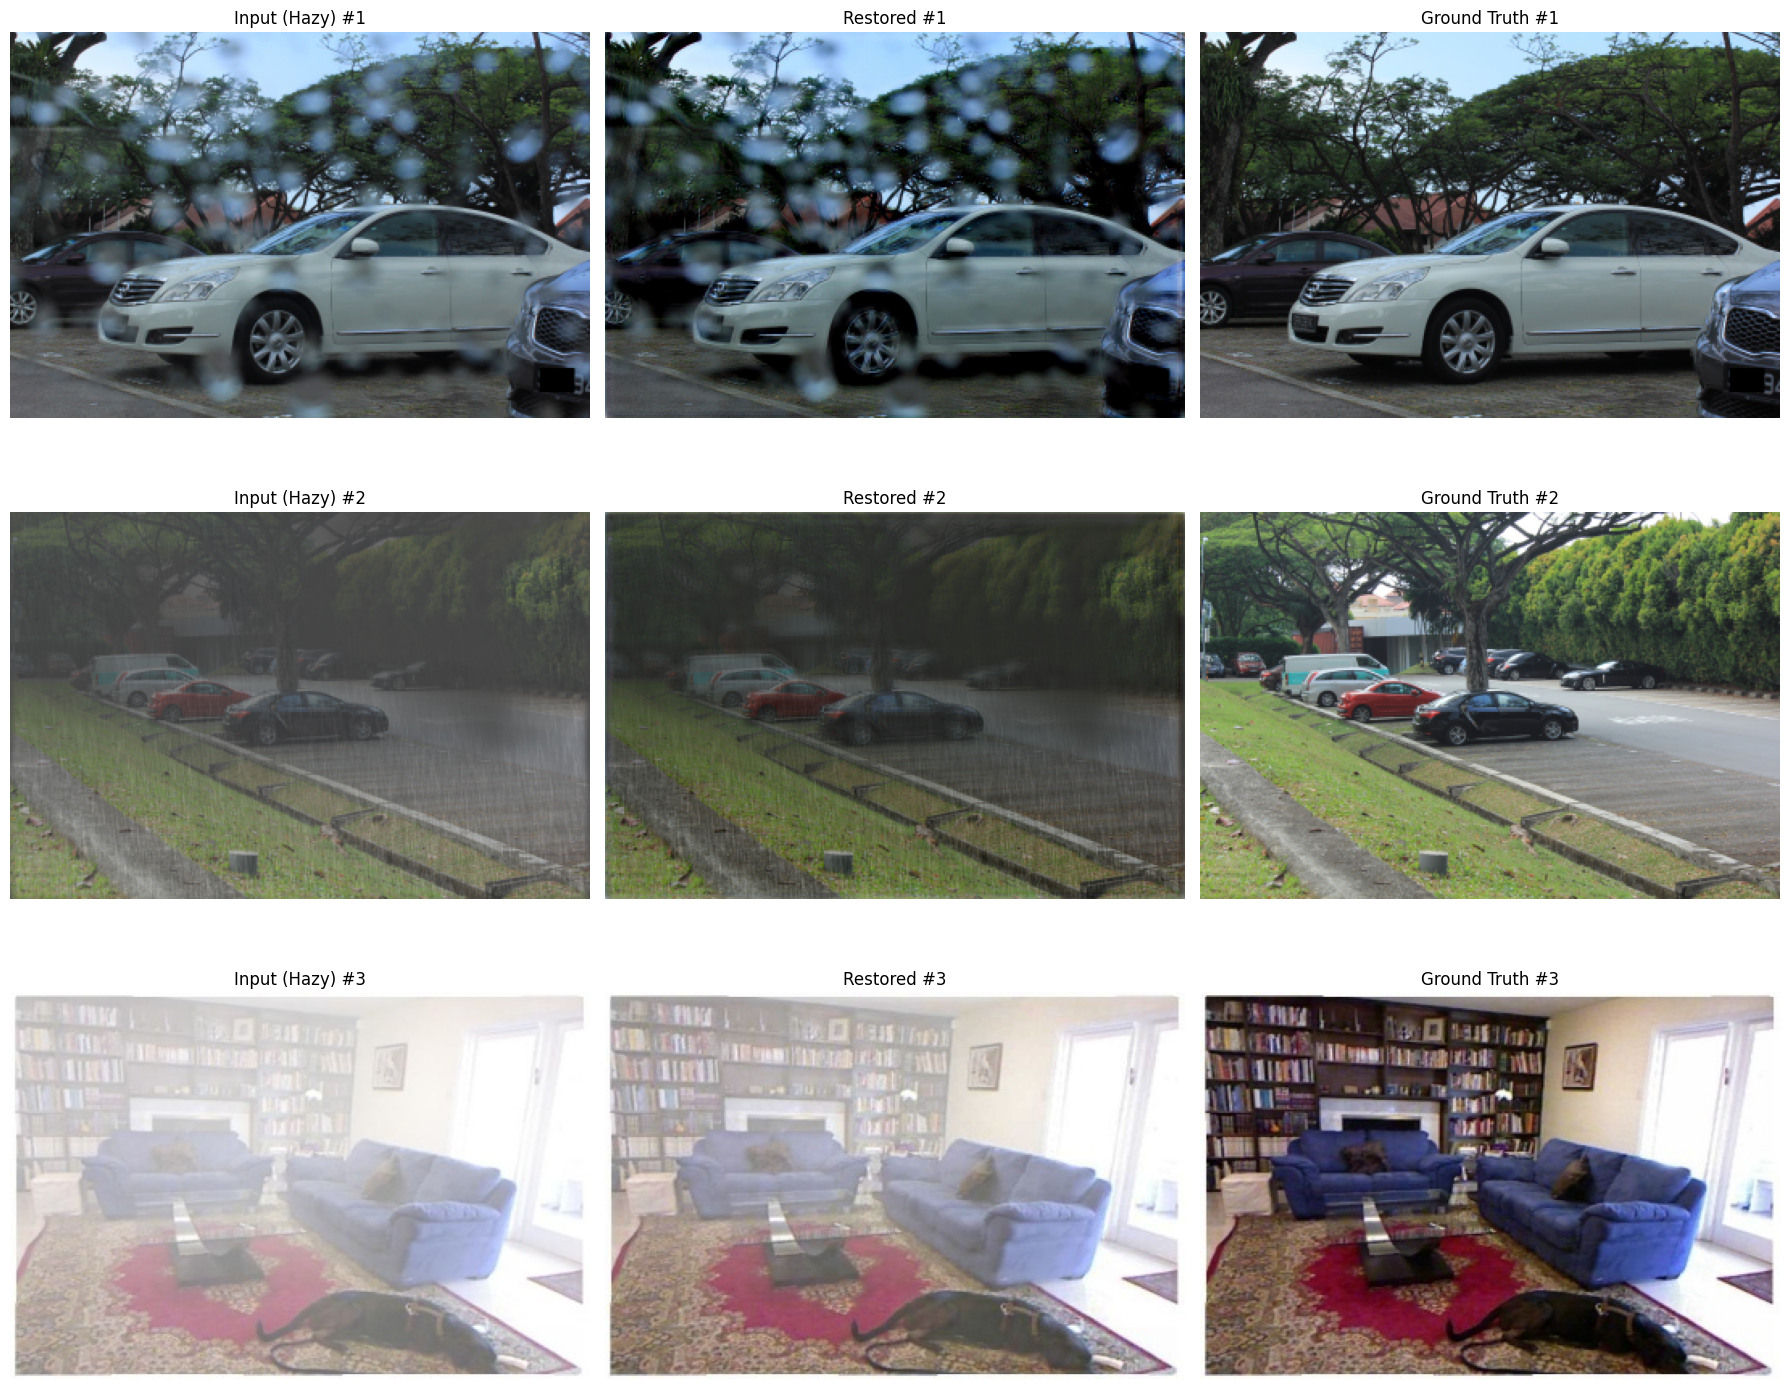


이미지 복원 및 비교 완료!


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import os

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 불러올 학습된 모델 가중치 파일의 경로
MODEL_WEIGHTS_PATH = "pt/TBaodNet5/best_model_epoch_96.pth"

# 2. 복원할 안개 이미지(input) 파일 경로들을 리스트 형태로 지정
HAZY_IMAGE_PATHS = [
    "dataset_split/test/input/51_rain.png",
    "dataset_split/test/input/im_0048_s95_a06.png",
    "dataset_split/test/input/NYU2_1331.jpg"
]

# 3. 정답 이미지(gt)가 들어있는 폴더 경로
GT_BASE_DIR = "dataset_split/test/gt"

# 4. 모델 학습 시 사용했던 이미지 해상도
TARGET_IMAGE_SIZE = (240, 360)
# ----------------------------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AODnet_MultiBranch().to(DEVICE) # DEVICE는 이전 셀에서 정의됨
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval()

# 이미지 전처리 transform 정의
transform = transforms.Compose([
    transforms.Resize(TARGET_IMAGE_SIZE),
    transforms.ToTensor()
])

# 결과를 저장할 리스트 생성
hazy_images_pil = []
restored_images_pil = []
clean_images_pil = []

print("이미지 복원을 시작합니다...")

for hazy_path in HAZY_IMAGE_PATHS:
    try:
        filename = os.path.basename(hazy_path)
        
        # ★★★ 수정된 부분 ★★★
        # os.path.join으로 생성된 경로를 os.path.normpath로 정규화
        clean_path_raw = os.path.join(GT_BASE_DIR, filename)
        clean_path = os.path.normpath(clean_path_raw)
        
        if not os.path.exists(clean_path):
            print(f"경고: 짝이 되는 정답 이미지 '{clean_path}'를 찾을 수 없습니다. 건너뜁니다.")
            continue

        hazy_image = Image.open(hazy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')
        
        hazy_tensor = transform(hazy_image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            restored_tensor = evaluation_model(hazy_tensor)

        restored_image = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

        hazy_images_pil.append(hazy_image)
        restored_images_pil.append(restored_image)
        clean_images_pil.append(clean_image)
        print(f"'{hazy_path}' 복원 및 정답 이미지 로드 완료.")

    except FileNotFoundError:
        print(f"오류: '{hazy_path}' 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요.")
    except Exception as e:
        print(f"'{hazy_path}' 처리 중 오류 발생: {e}")

# --- 시각화 부분 ---
if hazy_images_pil:
    num_images = len(hazy_images_pil)
    # 3개의 행(이미지 쌍), 3개의 열(Input, Restored, GT)
    plt.figure(figsize=(18, 5 * num_images)) 

    for i in range(num_images):
        # --- i번째 이미지 쌍 ---
        
        # 1열: 입력(Hazy) 이미지
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(hazy_images_pil[i])
        plt.title(f'Input (Hazy) #{i+1}')
        plt.axis('off')

        # 2열: 복원된 이미지
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(restored_images_pil[i])
        plt.title(f'Restored #{i+1}')
        plt.axis('off')
        
        # 3열: 정답(GT) 이미지
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(clean_images_pil[i])
        plt.title(f'Ground Truth #{i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("\n이미지 복원 및 비교 완료!")

In [ ]:
# onnx 변환용 셀
# pth_to_onnx.py
import torch

# 1. 모델 구조 불러오기 및 가중치 로드
model = AODnet_MultiBranch()
model.load_state_dict(torch.load('./pt/TBaodNet2/best_model_epoch_96.pth', map_location='cpu'))
model.eval() # 반드시 evaluation 모드로 설정!

# 2. 모델에 입력될 더미 데이터 생성 (중요!)
# 모델이 학습할 때 사용한 이미지 크기와 동일하게 맞춰주세요.
# 예: (배치크기, 채널, 높이, 너비)
dummy_input = torch.randn(1, 3, 240, 360) 

# 3. ONNX 파일로 변환
onnx_file_path = "aodnet2.onnx"
torch.onnx.export(model,
                  dummy_input,
                  onnx_file_path,
                  export_params=True,
                  opset_version=11, # 호환성을 위해 버전을 명시하는 것이 좋음
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'])

print(f"모델이 {onnx_file_path} 파일로 성공적으로 변환되었습니다.")

[Model] Multi-Branch AODNet 초기화 중...
[Model] Multi-Branch AODNet 초기화 완료

모델이 aodnet2.onnx 파일로 성공적으로 변환되었습니다.


In [3]:
# TFLite 변환용 셀

# 1. 필요 라이브러리 설치 (최초 1회만 실행)
# !pip install onnx onnx-tf tensorflow

import tensorflow as tf
import onnx
from onnx_tf.backend import prepare
import numpy as np
import os

# --- 설정 ---
onnx_file_path = "aodnet2.onnx"
saved_model_dir = "C:/temp/aodnet_tf_model"
quantized_tflite_path = "aodnet_quant_int8.tflite"


# 2. ONNX 모델을 TensorFlow SavedModel 형식으로 변환 (TFLite 변환을 위한 중간 단계)
print("ONNX 모델을 TensorFlow SavedModel로 변환하는 중...")
onnx_model = onnx.load(onnx_file_path)
tf_rep = prepare(onnx_model)
tf_rep.export_graph(saved_model_dir)
print(f"모델이 '{saved_model_dir}' 폴더에 저장되었습니다.")


# 3. 대표 데이터셋 준비 (가장 중요!)
# 모델의 가중치를 float32에서 int8로 변환할 때, 어떤 값 범위를 기준으로 삼을지 알려주는 샘플 데이터입니다.
# 실제 모델에 입력될 이미지와 유사한 데이터 100~200개를 사용하면 정확도가 높아집니다.
def representative_data_gen():
  print("대표 데이터셋 생성 중...")
  # 참고: 여기서는 랜덤 데이터를 생성했지만, 실제로는 학습에 사용했던 데이터나
  # 라즈베리파이에서 촬영될 이미지와 비슷한 샘플 이미지들을 전처리해서 사용해야 합니다.
  for _ in range(100):
    # PyTorch 모델의 입력 형식과 동일하게 (배치, 채널, 높이, 너비) 순서로 생성
    dummy_input = np.random.rand(1, 3, 240, 360).astype(np.float32)
    yield [dummy_input]
  print("대표 데이터셋 생성 완료.")


# 4. TFLite 변환기 설정 및 정수 양자화
print("TFLite 변환 및 정수 양자화 시작...")
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# 모든 연산을 INT8로 강제하여 최대 성능 확보 (호환성 문제가 발생하면 이 줄을 주석 처리)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# 5. 모델 변환 및 저장
tflite_quant_model = converter.convert()

with open(quantized_tflite_path, 'wb') as f:
  f.write(tflite_quant_model)

print("-" * 50)
print(f"✅ 정수 양자화된 모델 '{quantized_tflite_path}'이 성공적으로 저장되었습니다.")
print(f"이 파일을 라즈베리파이로 옮겨서 테스트하세요!")
print("-" * 50)

ONNX 모델을 TensorFlow SavedModel로 변환하는 중...
INFO:tensorflow:Assets written to: C:/temp/aodnet_tf_model\assets


INFO:tensorflow:Assets written to: C:/temp/aodnet_tf_model\assets


모델이 'C:/temp/aodnet_tf_model' 폴더에 저장되었습니다.
TFLite 변환 및 정수 양자화 시작...
대표 데이터셋 생성 중...
대표 데이터셋 생성 완료.
--------------------------------------------------
✅ 정수 양자화된 모델 'aodnet_quant_int8.tflite'이 성공적으로 저장되었습니다.
이 파일을 라즈베리파이로 옮겨서 테스트하세요!
--------------------------------------------------


In [ ]:
# onnx_to_tflite.py
#

import tensorflow as tf
from onnx_tf.backend import prepare
import onnx

# 1. ONNX 모델 로드
onnx_model = onnx.load("aodnet.onnx")
tf_rep = prepare(onnx_model)

# 2. TensorFlow SavedModel 형식으로 임시 저장
save_path = "C:/temp/aodnet_tf_model"
tf_rep.export_graph(save_path)

# 3. TensorFlow Lite 변환기 생성
# converter = tf.lite.TFLiteConverter.from_saved_model("aodnet_tf_model") # 기존 코드
converter = tf.lite.TFLiteConverter.from_saved_model(save_path) # 변경된 코드

# 4. (강력 추천) 8비트 정수형으로 양자화하여 최적화
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 양자화를 위해 대표 데이터셋(representative dataset) 제공이 필요할 수 있습니다.
# 이는 모델이 실제 처리할 데이터의 분포를 알려주는 역할을 합니다.
# 예: 실제 안개 낀 이미지 100장을 전처리하여 사용
# def representative_data_gen():
#   for image in representative_dataset:
#     # 이미지를 모델 입력에 맞게 전처리 (리사이즈, 정규화 등)
#     processed_image = preprocess(image) 
#     yield [processed_image]
# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


# 5. TensorFlow Lite 모델로 변환
tflite_model = converter.convert()

# 6. .tflite 파일로 저장
with open("aodnet_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TensorFlow Lite 모델(aodnet_model.tflite) 변환 및 저장 완료!")

INFO:tensorflow:Assets written to: C:/temp/aodnet_tf_model\assets


INFO:tensorflow:Assets written to: C:/temp/aodnet_tf_model\assets


TensorFlow Lite 모델(aodnet_model.tflite) 변환 및 저장 완료!


In [ ]:
#!/usr/bin/python3
import cv2
import numpy as np
import time
from picamera2 import Picamera2
from tensorflow.lite.python.interpreter import Interpreter

# --- 설정 ---
MODEL_PATH = 'aodnet_quant_int8.tflite'
# ★ 모델의 입력 크기에 맞게 너비(WIDTH)와 높이(HEIGHT) 순서를 확인하고 수정합니다.
# 모델 입력이 (1, 3, 240, 360) 이므로 높이(H)=240, 너비(W)=360 입니다.
WIDTH, HEIGHT = 360, 240

def main():
    # --- 1. TFLite 모델 로드 ---
    try:
        interpreter = Interpreter(model_path=MODEL_PATH, num_threads=4)
        interpreter.allocate_tensors()
        
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        model_input_shape = input_details[0]['shape']
        print(f"모델이 요구하는 실제 입력 형태: {model_input_shape}")

        # ⭐️ 모델의 입력 데이터 타입이 INT8인지 확인합니다.
        is_int8_model = (input_details[0]['dtype'] == np.int8)
        
        if is_int8_model:
            print("INFO: 모델이 int8 입력을 사용합니다. 정수형으로 변환합니다.")
            # ⭐️ INT8 변환에 필요한 스케일과 제로 포인트를 미리 가져옵니다.
            input_quant_params = input_details[0]['quantization_parameters']
            input_scale = input_quant_params['scales'][0]
            input_zero_point = input_quant_params['zero_points'][0]
            
            output_quant_params = output_details[0]['quantization_parameters']
            output_scale = output_quant_params['scales'][0]
            output_zero_point = output_quant_params['zero_points'][0]
        else:
            print("INFO: 모델이 float32 입력을 사용합니다. 실수형으로 처리합니다.")

    except Exception as e:
        print(f"모델 로딩에 실패했습니다: {e}")
        return

    # --- 2. 카메라 설정 ---
    picam2 = Picamera2()
    config = picam2.create_preview_configuration(
        main={"size": (WIDTH, HEIGHT), "format": "RGB888"}
    )
    picam2.configure(config)
    picam2.start()
    time.sleep(1)
    print("카메라가 시작되었습니다.")

    fps_counter = 0
    start_time = time.time()

    try:
        while True:
            frame_original = picam2.capture_array()
            # 프레임 회전이 필요하다면 아래 코드의 주석을 해제하세요.
            frame = cv2.rotate(frame_original, cv2.ROTATE_180) 
            # frame = frame_original # 회전이 필요 없다면 이 줄을 사용

            # --- 3. 입력 데이터 전처리 ---
            # 모델의 입력 형태 (1, C, H, W)에서 높이와 너비를 가져옵니다.
            _, _, model_height, model_width = model_input_shape
            input_image = cv2.resize(frame, (model_width, model_height))
            
            # 배치 차원 추가 (H, W, C) -> (1, H, W, C)
            input_data = np.expand_dims(input_image, axis=0)
            
            # ⭐️ INT8 모델을 위한 데이터 양자화 (가장 중요한 부분)
            if is_int8_model:
                # uint8 (0~255) -> float32 (0.0~1.0)
                input_data_float = input_data.astype(np.float32) / 255.0
                # float32 (0.0~1.0) -> int8 (-128~127)
                input_data = (input_data_float / input_scale + input_zero_point).astype(np.int8)
            else: # float32 모델의 경우
                input_data = (input_data.astype(np.float32) / 255.0)

            # TensorFlow(NHWC) -> ONNX/PyTorch(NCHW) 순서로 변경
            # (1, H, W, C) -> (1, C, H, W)
            input_data = np.transpose(input_data, (0, 3, 1, 2))

            # --- 4. 모델 추론 ---
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # --- 5. 출력 데이터 후처리 ---
            # ONNX/PyTorch(NCHW) -> TensorFlow(NHWC) 순서로 변경
            # (1, C, H, W) -> (1, H, W, C)
            output_data_nhwc = np.transpose(output_data, (0, 2, 3, 1))
            
            # ⭐️ INT8 모델의 출력값을 이미지로 변환 (역양자화)
            if is_int8_model:
                # int8 (-128~127) -> float32 (0.0~1.0)
                output_data_float = (output_data_nhwc.astype(np.float32) - output_zero_point) * output_scale
                # float32 -> uint8 (0~255)
                processed_image = np.clip(output_data_float[0] * 255.0, 0, 255).astype(np.uint8)
            else: # float32 모델의 경우
                processed_image = (output_data_nhwc[0] * 255.0).astype(np.uint8)
            
            # --- 6. 결과 출력 ---
            processed_bgr = cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR)
            cv2.imshow('Processed by TFLite', processed_bgr)

            fps_counter += 1
            if time.time() - start_time >= 1:
                print(f"FPS: {fps_counter}")
                fps_counter = 0
                start_time = time.time()
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
    finally:
        print("프로그램을 종료합니다.")
        picam2.stop()
        cv2.destroyAllWindows()

if __name__ == '__main__':
    main()